In [4]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-_jen7c41
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-_jen7c41
  Resolved https://github.com/paulgavrikov/visualkeras to commit 8d42f3a9128373eac7b4d38c23a17edc9357e3c9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 27.2 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.1.4-py3-none-any.whl size=17145 sha256=5224ca38df09845839d11fc917af95b64fe0066d8085ce0f1454726dca745eb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bbud5ymf/wheels/be/f7/2b/90cdf278d2022271c504be10866520c5d94d4a82c919b77302
Successfully built visualkeras


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instances (m): 1,000
- Squence length (per instance): 30 sec
- Labels: 10 (Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparing the dataset.


### Steps
1. Create the dataset. Feature Engineering
2. Fit the CNN to the dataset
3. Evaluate the performance

### Creating the dataset
Based on the different resources I am finding online (Kaggle and some blog posts), it seems like the way to go is to extract meaningful features from the data, shape them so that they share dimensions and build a tensor out of them.
The most interesting feature was the Mel-Spectogram

## 1. Setup, Data, Feature Engineering

In [8]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)


# Define the target path
target_path = '/kaggle/working/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

# print("Path to dataset files:", download_path)


100%|██████████| 1.21G/1.21G [00:31<00:00, 40.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dataset successfully moved to: /kaggle/working/gtzan-dataset-music-genre-classification


In [12]:
# Setup: path, one-hot vector for the labels
# ----------------

path =  r"/kaggle/working/gtzan-dataset-music-genre-classification/1/Data/genres_original"
labels = [f.name for f in os.scandir(path) if f.is_dir()]

# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

for folder in labels:
    folder_path = os.path.join(path, folder)  # Ensures proper path formatting
    files = os.listdir(folder_path)  # List files in the correct folder
    for file in files:
        if file.endswith('.wav'):
            n_files += 1

['country', 'classical', 'reggae', 'rock', 'metal', 'hiphop', 'pop', 'jazz', 'blues', 'disco']
country [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
classical [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rock [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
metal [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
pop [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
blues [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
disco [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
# Global variables
# ----------------

H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform


In [21]:
import os
import numpy as np
import librosa as lb
import h5py

# Constants
N_SLICES = 5  # Adjust based on sample length
AUGMENTATION_MULTIPLIER = 5  # Number of augmentations per sample

def read_sample(file):
    """Load a single audio file."""
    y, sr = lb.load(file, sr=None)  # Keep original sample rate
    return y, sr

def augment_sample(sample, sr):
    """
    Perform data augmentation.
    Returns a generator that yields augmented samples instead of storing them all in RAM.
    """
    samples = np.array_split(sample, N_SLICES)
    for sample_ in samples:
        yield sample_  # Original

        for n_steps in [4, 6]:  # Pitch Shift
            yield lb.effects.pitch_shift(y=sample_, sr=sr, n_steps=n_steps)

        for rate in [0.5, 2.0]:  # Time Stretch
            yield lb.effects.time_stretch(y=sample_, rate=rate)

        wn = np.random.randn(len(sample_))  # White Noise
        yield sample_ + 0.005 * wn

def process_and_store_data(path, folders, output_file="dataset.h5", batch_size=100):
    """
    Reads and processes the dataset in batches, storing it in an HDF5 file to avoid memory overflow.
    """
    # Get input length from the first file
    input_length = None
    for folder in folders:
        files = [f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')]
        if files:
            sample, sr = read_sample(os.path.join(path, folder, files[0]))
            input_length = len(sample) // N_SLICES
            break

    if input_length is None:
        raise ValueError("No valid WAV files found.")

    # Determine dataset size dynamically
    total_samples = sum(len([f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')])
                        * AUGMENTATION_MULTIPLIER for folder in folders)

    # Create HDF5 file for storage
    with h5py.File(output_file, "w") as f:
        x_dataset = f.create_dataset("X", (total_samples, input_length), dtype=np.float32)
        y_dataset = f.create_dataset("Y", (total_samples, 10), dtype=np.uint8)

        idx = 0
        for folder in folders:
            print(f"Processing {folder}...")
            files = [f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')]
            for file in files:
                sample, sr = read_sample(os.path.join(path, folder, file))
                for aug_sample in augment_sample(sample, sr):
                    if len(aug_sample) > input_length:
                        aug_sample = aug_sample[:input_length]
                    else:
                        aug_sample = np.pad(aug_sample, (0, input_length - len(aug_sample)))

                    x_dataset[idx] = aug_sample
                    y_dataset[idx] = oh_dict[folder]  # One-hot encoding
                    idx += 1

                    if idx % batch_size == 0:
                        print(f"Processed {idx}/{total_samples} samples...")

        print(f"Data processing complete! Stored in {output_file}.")

def load_data_from_hdf5(file="dataset.h5"):
    """
    Load dataset from HDF5 file without excessive memory usage.
    """
    with h5py.File(file, "r") as f:
        X = f["X"][:]
        Y = f["Y"][:]
    return X, Y


In [22]:
# Reading raw data from files
# -------------
# saving it into disk in case we need to load it

x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)
# np.save('../data/x_raw_3_slice', x_raw)
# np.save('../data/y_raw_3_slice', y_raw)

(18000, 132358) (18000, 10)
Reading country


KeyboardInterrupt: 

In [ ]:
plt.plot(x_raw[:,0])

In [ ]:
# Run only if we are loading the data

x_raw = np.load('../data/x_raw_3_slice.npy')
y_raw = np.load('../data/y_raw_3_slice.npy')
_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [ ]:
# Creating the tensor with the features
# -----------

X = create_dataset(x_raw, sr)
Y = np.copy(y_raw)
print(X.shape)
print(Y.shape)

(18000, 128, 431, 1)
(18000, 10)


In [ ]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [ ]:
# Train, validation, test split
# ------------
# 80% for training, 10% for validation and 10% for testing

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {x_train.shape} {y_train.shape}')
print(f'Valid: {x_val.shape}   {y_val.shape}')
print(f'Test:  {x_test.shape}  {y_test.shape}')


Train: (14400, 128, 431, 1) (14400, 10)
Valid: (1800, 128, 431, 1)   (1800, 10)
Test:  (1800, 128, 431, 1)  (1800, 10)


## 2. Modeling
- CNN-64
- LeNet-5

### LeNet-5

In [ ]:
# LeNet-5
# -----
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

In [ ]:
lenet = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
lenet.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
lenet.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 431, 1)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 429, 8)       80        
_________________________________________________________________
average_pooling2d_2 (Average (None, 63, 214, 8)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 214, 8)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 212, 16)       1168      
_________________________________________________________________
average_pooling2d_3 (Average (None, 30, 106, 16)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 106, 16)       0   

In [ ]:
epochs = 20

history_lenet = lenet.fit(x=x_train,
                          y=y_train,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          shuffle=True)

Epoch 1/20
450/450 [==============================] - 111s 245ms/step - loss: 1.8968 - accuracy: 0.3035 - val_loss: 1.6332 - val_accuracy: 0.4133
Epoch 2/20
450/450 [==============================] - 101s 224ms/step - loss: 1.4993 - accuracy: 0.4564 - val_loss: 1.3039 - val_accuracy: 0.5500
Epoch 3/20
450/450 [==============================] - 101s 225ms/step - loss: 1.2724 - accuracy: 0.5460 - val_loss: 1.1724 - val_accuracy: 0.5828
Epoch 4/20
450/450 [==============================] - 101s 225ms/step - loss: 1.0858 - accuracy: 0.6142 - val_loss: 1.0174 - val_accuracy: 0.6500
Epoch 5/20
450/450 [==============================] - 102s 226ms/step - loss: 0.9215 - accuracy: 0.6750 - val_loss: 0.8992 - val_accuracy: 0.6933
Epoch 6/20
450/450 [==============================] - 101s 225ms/step - loss: 0.8144 - accuracy: 0.7126 - val_loss: 0.8685 - val_accuracy: 0.7144
Epoch 7/20
450/450 [==============================] - 101s 225ms/step - loss: 0.7196 - accuracy: 0.7465 - val_loss: 0.8422 -

In [ ]:
lenet.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 4s 66ms/step - loss: 1.0697 - accuracy: 0.7456


[1.069667100906372, 0.745555579662323]

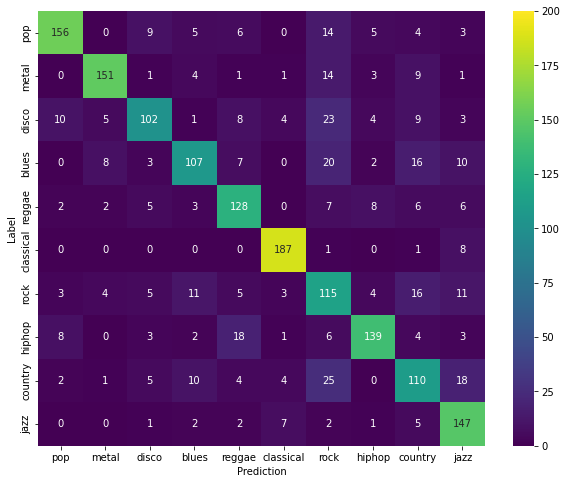

In [ ]:
# HeatMap LeNet

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(lenet.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("../png/lenet_confmatrix.png", dpi=150)
plt.show()

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

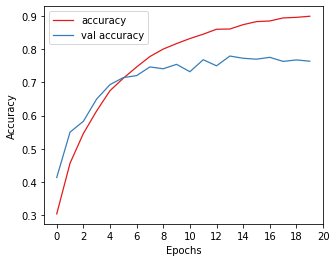

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), history_lenet.history['accuracy'], label='accuracy', lw=1.25)
ax.plot(range(epochs), history_lenet.history['val_accuracy'], label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,2)])
ax.legend()
plt.savefig("../png/lenet_acc_epochs.png", dpi=150)

plt.show()

### CNN-64

In [ ]:
# CNN-64 Resizing + FC
# --------

n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape)
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [ ]:
# Original
# ---------

n_filters = 64
inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [ ]:
# Building the model. Compiling
# --------------
# Loss: Categorical Cross Entropy, since we have one-hot vectors.

model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 431, 1)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0   

In [ ]:
epochs = 20

history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
450/450 [==============================] - 199s 439ms/step - loss: 1.9575 - accuracy: 0.2879 - val_loss: 1.5915 - val_accuracy: 0.4517
Epoch 2/20
450/450 [==============================] - 185s 412ms/step - loss: 1.5291 - accuracy: 0.4501 - val_loss: 1.4834 - val_accuracy: 0.4894
Epoch 3/20
450/450 [==============================] - 184s 408ms/step - loss: 1.3348 - accuracy: 0.5252 - val_loss: 1.1925 - val_accuracy: 0.5883
Epoch 4/20
450/450 [==============================] - 184s 408ms/step - loss: 1.2121 - accuracy: 0.5757 - val_loss: 1.0906 - val_accuracy: 0.6333
Epoch 5/20
450/450 [==============================] - 192s 427ms/step - loss: 1.1081 - accuracy: 0.6046 - val_loss: 0.9628 - val_accuracy: 0.6622
Epoch 6/20
450/450 [==============================] - 198s 439ms/step - loss: 1.0105 - accuracy: 0.6424 - val_loss: 0.8562 - val_accuracy: 0.7033
Epoch 7/20
450/450 [==============================] - 199s 441ms/step - loss: 0.9339 - accuracy: 0.6614 - val_loss: 0.8464 -

In [ ]:
history2 = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=20,
                    epochs=50,
                    shuffle=True)

Epoch 21/50
450/450 [==============================] - 236s 524ms/step - loss: 0.4612 - accuracy: 0.8306 - val_loss: 0.5855 - val_accuracy: 0.8139
Epoch 22/50
450/450 [==============================] - 191s 425ms/step - loss: 0.4392 - accuracy: 0.8389 - val_loss: 0.5825 - val_accuracy: 0.8067
Epoch 23/50
450/450 [==============================] - 182s 404ms/step - loss: 0.4205 - accuracy: 0.8467 - val_loss: 0.6201 - val_accuracy: 0.8094
Epoch 24/50
450/450 [==============================] - 180s 400ms/step - loss: 0.4138 - accuracy: 0.8504 - val_loss: 0.5520 - val_accuracy: 0.8411
Epoch 25/50
450/450 [==============================] - 179s 398ms/step - loss: 0.3917 - accuracy: 0.8593 - val_loss: 0.6241 - val_accuracy: 0.8122
Epoch 26/50
450/450 [==============================] - 179s 397ms/step - loss: 0.3837 - accuracy: 0.8609 - val_loss: 0.6205 - val_accuracy: 0.8250
Epoch 27/50
450/450 [==============================] - 180s 400ms/step - loss: 0.3748 - accuracy: 0.8620 - val_loss: 0

In [ ]:
history3 = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=50,
                    epochs=100,
                    shuffle=True)

Epoch 51/100
450/450 [==============================] - 221s 489ms/step - loss: 0.2459 - accuracy: 0.9124 - val_loss: 0.5377 - val_accuracy: 0.8617
Epoch 52/100
450/450 [==============================] - 184s 408ms/step - loss: 0.2428 - accuracy: 0.9131 - val_loss: 0.5973 - val_accuracy: 0.8617
Epoch 53/100
450/450 [==============================] - 181s 401ms/step - loss: 0.2368 - accuracy: 0.9147 - val_loss: 0.5645 - val_accuracy: 0.8583
Epoch 54/100
450/450 [==============================] - 178s 395ms/step - loss: 0.2273 - accuracy: 0.9205 - val_loss: 0.5349 - val_accuracy: 0.8617
Epoch 55/100
450/450 [==============================] - 178s 395ms/step - loss: 0.2385 - accuracy: 0.9174 - val_loss: 0.5395 - val_accuracy: 0.8572
Epoch 56/100
450/450 [==============================] - 178s 394ms/step - loss: 0.2241 - accuracy: 0.9199 - val_loss: 0.5114 - val_accuracy: 0.8639
Epoch 57/100
450/450 [==============================] - 177s 394ms/step - loss: 0.2199 - accuracy: 0.9224 - val_

In [ ]:
model.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 5s 82ms/step - loss: 0.6635 - accuracy: 0.8528


[0.6635146737098694, 0.8527777791023254]

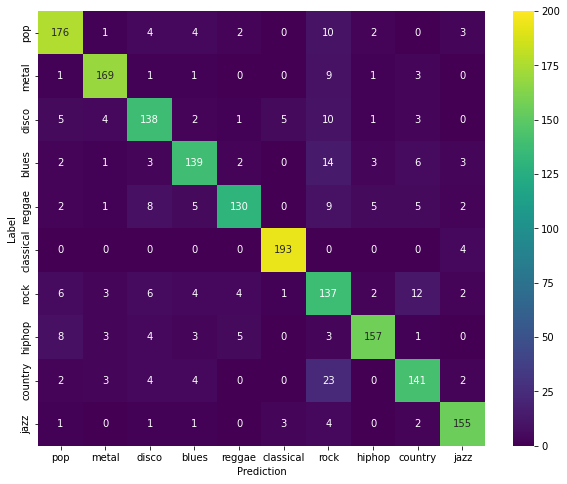

In [ ]:
# HeatMap CNN64 filtered

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels,
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("../png/cnn64_confmatrix.png", dpi=150)
plt.show()

In [ ]:
model.save('../models/model1')

INFO:tensorflow:Assets written to: ../models/model1/assets


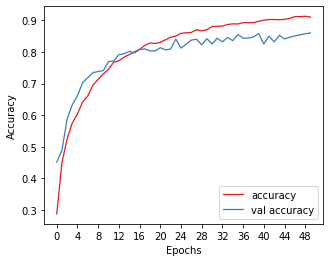

In [ ]:
epochs = 50
hist_acc = history.history['accuracy'] + history2.history['accuracy']
hist_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("../png/cnn64_acc_epochs.png", dpi=150)

plt.show()